In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

In [3]:
# import raw data and params.txt file

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [4]:
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

The Echo pulse occurs at timestep: 628


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rf

# Time-series Classification

In [6]:
y = params['stencil_type'].values
X_train, X_test, y_train, y_test = train_test_split(rscl_data, y, test_size=0.20, random_state=42)

In [7]:
model = rf(n_estimators=40, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)

In [8]:
%time model.fit(X_train, y_train)

CPU times: user 1min, sys: 64.9 ms, total: 1min 1s
Wall time: 31.5 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [9]:
model.score(X_test,y_test)

0.9680952380952381

In [10]:
imp = model.feature_importances_
imp_df = pd.DataFrame(imp, columns=['FE'])
imp_df.head()

,FE
0,0.001846
1,0.001170
2,0.000727
3,0.000907
4,0.001483


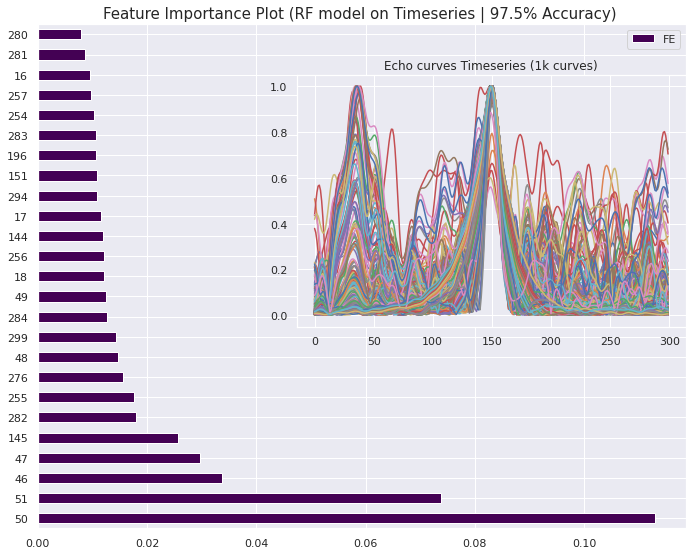

In [11]:
fig = plt.figure(figsize=(9,7))
sns.despine()

ax1 = fig.add_axes([0.1,0.1,1.0,1.0])
ax2 = fig.add_axes([0.5,0.5,0.6,0.5])

imp_df.sort_values("FE", ascending=False).head(25).plot.barh(ax=ax1, cmap='viridis')

ax2.set_title(f'Echo curves Timeseries (1k curves)')
for i in np.random.randint(low=0,high=10499, size=1000):
    ax2.plot(rscl_data[i,:])

ax1.set_title("Feature Importance Plot (RF model on Timeseries | 97.5% Accuracy) ", fontsize=15)

plt.show()

# Polynomial Features Dataset

In [23]:
%time polyfeat = poly_featextract(rscl_data, n_splits=[4,5,10], order_fits=[3,3,3], as_df=True )

CPU times: user 24.6 s, sys: 790 ms, total: 25.3 s
Wall time: 24.3 s


In [25]:
polyfeat.head()

,4_1_0,4_1_1,4_1_2,4_1_3,4_2_0,4_2_1,4_2_2,4_2_3,4_3_0,4_3_1,4_3_2,4_3_3,4_4_0,4_4_1,4_4_2,4_4_3,5_1_0,5_1_1,5_1_2,5_1_3,5_2_0,5_2_1,5_2_2,5_2_3,5_3_0,5_3_1,5_3_2,5_3_3,5_4_0,5_4_1,5_4_2,5_4_3,5_5_0,5_5_1,5_5_2,5_5_3,10_1_0,10_1_1,10_1_2,10_1_3,10_2_0,10_2_1,10_2_2,10_2_3,10_3_0,10_3_1,10_3_2,10_3_3,10_4_0,10_4_1,10_4_2,10_4_3,10_5_0,10_5_1,10_5_2,10_5_3,10_6_0,10_6_1,10_6_2,10_6_3,10_7_0,10_7_1,10_7_2,10_7_3,10_8_0,10_8_1,10_8_2,10_8_3,10_9_0,10_9_1,10_9_2,10_9_3,10_10_0,10_10_1,10_10_2,10_10_3
0,2.236470e-07,0.000006,0.000135,0.011056,0.000004,0.000259,0.007989,0.151059,-0.000004,0.000274,-0.008279,0.146295,-2.149142e-07,6.155184e-06,-0.000127,0.010173,4.935040e-08,-9.564645e-07,0.000146,0.010836,0.000001,0.000088,0.002330,0.050902,-1.240647e-06,-0.000796,0.000025,0.788313,-0.000002,0.000088,-0.002004,0.043527,-1.111921e-07,-9.397074e-07,-0.000102,0.009810,-0.000004,3.937090e-07,0.000778,0.007660,2.546425e-08,0.000025,0.000113,0.011351,0.000003,0.000015,0.000244,0.031908,0.000005,0.000144,0.005397,0.110987,0.000009,0.000671,0.025493,0.506981,4.403833e-08,0.000656,-0.026719,0.493492,-0.000005,0.000145,-0.005154,0.099619,-3.561492e-06,0.000002,-0.000040,0.029204,0.000001,0.000023,-0.000220,0.010351,0.000003,-4.742968e-07,-0.000630,0.007237
1,2.215008e-07,0.000007,0.000148,0.011400,0.000004,0.000257,0.008087,0.155030,-0.000004,0.000277,-0.008140,0.139200,-2.150578e-07,5.847759e-06,-0.000100,0.009622,5.348174e-08,-7.629909e-07,0.000151,0.011101,0.000001,0.000088,0.002405,0.052983,-8.409480e-07,-0.000797,-0.000491,0.787621,-0.000002,0.000088,-0.001867,0.039771,-8.054800e-08,-1.246002e-06,-0.000098,0.009474,-0.000004,3.085515e-06,0.000780,0.007683,6.577916e-08,0.000028,0.000119,0.011560,0.000003,0.000017,0.000310,0.033036,0.000005,0.000144,0.005447,0.114158,0.000009,0.000658,0.025438,0.512003,-4.031903e-07,0.000675,-0.026876,0.485822,-0.000005,0.000146,-0.005067,0.093880,-3.919389e-06,-0.000003,0.000076,0.027217,0.000001,0.000016,-0.000196,0.010274,0.000003,-7.368338e-06,-0.000562,0.007548
2,3.011159e-07,0.000003,0.000062,0.015478,0.000004,0.000259,0.007630,0.150626,-0.000006,0.000335,-0.006469,0.054775,1.576197e-07,-4.457968e-07,-0.000172,0.005378,1.130315e-07,-6.060069e-06,0.000133,0.015633,0.000001,0.000084,0.002449,0.053891,6.345069e-07,-0.000842,-0.003147,0.763734,-0.000003,0.000060,0.000137,0.004831,2.699844e-07,3.462030e-06,-0.000216,0.004133,-0.000005,-7.924677e-06,0.001086,0.011249,5.534692e-07,0.000026,-0.000077,0.014808,0.000004,0.000024,0.000249,0.032969,0.000005,0.000132,0.005112,0.113869,0.000010,0.000707,0.025671,0.501332,-2.417518e-06,0.000851,-0.029530,0.405186,-0.000002,0.000219,-0.003503,0.021530,5.906804e-07,0.000006,-0.000393,0.007274,0.000003,-0.000022,-0.000514,0.008249,0.000002,-2.192772e-07,-0.000209,0.003928
3,3.582810e-06,-0.000153,0.003142,0.558517,-0.000004,0.000325,0.012640,0.249613,-0.000021,-0.000052,0.015769,0.671904,-1.123982e-05,-7.467075e-05,0.011848,0.386328,1.741358e-05,-2.428894e-04,-0.003017,0.518130,0.000002,0.000552,-0.010246,0.174025,5.025033e-06,-0.000381,-0.002618,0.771057,0.000023,-0.000455,-0.021611,0.691974,-1.166589e-05,-3.644715e-04,0.008965,0.474250,-0.000018,-1.136943e-04,0.019888,0.354187,6.979802e-05,0.002911,-0.011550,0.323371,-0.000007,0.000789,-0.020678,0.440769,-0.000007,0.000016,0.012085,0.181037,-0.000208,0.000602,0.045921,0.610748,-9.352134e-05,0.001560,0.001255,0.527728,-0.000060,-0.001001,0.023720,0.813619,-1.219899e-04,0.000352,0.002809,0.339447,0.000053,-0.000710,-0.002286,0.344669,-0.000009,-9.708227e-04,-0.012851,0.510316
4,1.944124e-07,0.000007,0.000210,0.012615,0.000004,0.000254,0.008289,0.162810,-0.000004,0.000285,-0.007789,0.123668,-2.987454e-07,4.270846e-06,0.000077,0.008701,2.661307e-08,1.556228e-07,0.000202,0.011918,0.000001,0.000090,0.002508,0.057282,3.756626e-08,-0.000801,-0.001610,0.785572,-0.000002,0.000084,-0.001624,0.031687,-1.269993e-07,-4.705512e-06,0.000014,0.009837,-0.000004,1.038820e-05,0.000740,0.007664,-2.213829e-07,0.000031,0.000210,0.012940,0.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(polyfeat, y, test_size=0.20, random_state=42)

In [65]:
model2 = rf(n_estimators=40, n_jobs=-1, max_features="sqrt", oob_score=True)

In [66]:
model2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [67]:
model2.score(X_test,y_test)

0.9838095238095238

In [31]:
imp = model2.feature_importances_
imp_df = pd.DataFrame(imp, columns=['FE'], index=polyfeat.columns)
imp_df.head()

,FE
4_1_0,0.000522
4_1_1,0.025866
4_1_2,0.022652
4_1_3,0.024160
4_2_0,0.002530


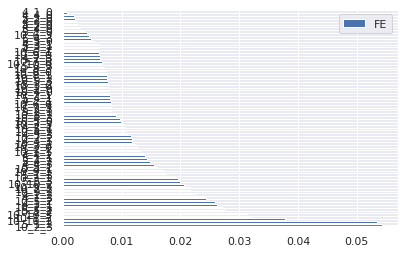

In [32]:
imp_df.sort_values("FE", ascending=False).plot.barh()

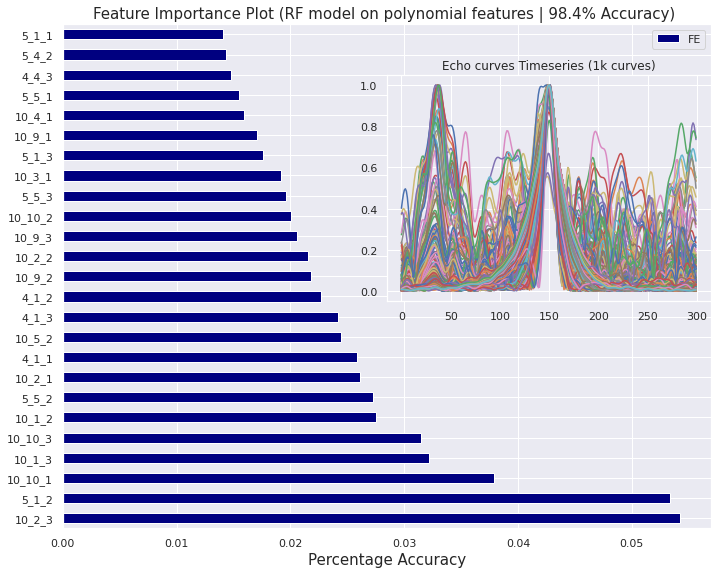

In [68]:
fig = plt.figure(figsize=(9,7))
sns.despine()

ax1 = fig.add_axes([0.1,0.1,1.0,1.0])
ax2 = fig.add_axes([0.6,0.55,0.5,0.45])

imp_df.sort_values("FE", ascending=False).head(25).plot.barh(ax=ax1, cmap='jet')

ax2.set_title(f'Echo curves Timeseries (1k curves)')
for i in np.random.randint(low=0,high=10499, size=1000):
    ax2.plot(rscl_data[i,:])

ax1.set_title("Feature Importance Plot (RF model on polynomial features | 98.4% Accuracy) ", fontsize=15)
ax1.set_xlabel("Percentage Accuracy", fontsize=15)

plt.show()

## Try with lesser number of columns

In [69]:
new_cols = imp_df[imp_df.FE >= 0.007].index.values

In [70]:
X_train, X_test, y_train, y_test = train_test_split(polyfeat[new_cols], y, test_size=0.20, random_state=42)

In [71]:
model3 = rf(n_estimators=40, n_jobs=-1, max_features="sqrt", oob_score=True)

In [72]:
model3.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [73]:
model3.score(X_test,y_test)

0.9838095238095238

# Unsupervised Learning

In [79]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA

In [80]:
pt, qt = PowerTransformer(method="box-cox"), QuantileTransformer(output_distribution="normal")

In [81]:
type(rscl_data[0,0])

numpy.float32

In [88]:
ptdata = pt.fit_transform(rscl_data)
qtdata =  qt.fit_transform(rscl_data)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [90]:
pca2d_ptdata, pca2d_ptvar = pca2D(ptdata)

In [102]:
pca2d_ptvar

array([0.4348876 , 0.19390495], dtype=float32)

In [ ]:
fig,ax = plt.subplots(figsize=(8,7))

cax = fig.add_axes([0.93, 0.2, 0.05, 0.6])

im = ax.scatter(pca2d_ptdata.PC1, pca2d_ptdata.PC2,
           c=ker_integrals.values, cmap='seismic')

# ax.set_xlabel("Principal Component 1", fontsize=15)
# ax.set_ylabel("Principal Component 2", fontsize=15)

# fig.colorbar(im, cax=cax, orientation='vertical')

In [112]:
?fig.add_axes